In [1]:
import os
import sys
import argparse
import time

import imageio
import torch
from tqdm.notebook import tqdm
import torchvision.transforms as T
from PIL import Image

sys.path.append("../StyleCLIP_modular")
from style_clip import Imagine, create_text_path

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=32, type=int)
parser.add_argument("--gradient_accumulate_every", default=1, type=int)
parser.add_argument("--save_every", default=1, type=int)
parser.add_argument("--epochs", default=1, type=int)
parser.add_argument("--story_start_words", default=5, type=int)
parser.add_argument("--story_words_per_epoch", default=5, type=int)
parser.add_argument("--style", default="../stylegan2-ada-pytorch/VisionaryArt.pkl", type=str, choices=["faces (ffhq config-f)", "../stylegan2-ada-pytorch/VisionaryArt.pkl"])
parser.add_argument("--lr_schedule", default=0, type=int)
parser.add_argument("--start_image_steps", default=1000, type=int)
parser.add_argument("--iterations", default=100, type=int)
args = vars(parser.parse_args({}))

args["opt_all_layers"] = 1
args["lr_schedule"] = 1
args["noise_opt"] = 0
args["reg_noise"] = 0
args["seed"] = 1

args["model_type"] = "vqgan"
args["iterations"] = 200
args["save_every"] = 1
args["start_img_loss_weight"] = 0.0
args["batch_size"] = 16

args["lr"] = 0.1

#run(img="base_images/aicpa_logo_black.jpg", start_image_path="base_images/stance.jpg", args=args)
#run(img="base_images/aicpa_logo_black.jpg", start_image_path="base_images/earth.jpg", args=args)
#run(img="base_images/earth.jpg", start_image_path="base_images/aicpa_logo_black.jpg", args=args)

In [3]:
imagine = Imagine(
                save_progress=False,
                open_folder=False,
                save_video=False,
                verbose=False,
                **args
               )

setting seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
args["start_image_steps"] = 500
args["sideX"] = 320
args["sideY"] = 320

path_dict = {"logo_black": "base_images/aicpa_logo_black.jpg",
        "logo_purple": "base_images/aicpa_logo_purple.jpg",
        "earth": "base_images/earth.jpg",
        "stance": "base_images/stance.jpg",
        }
latent_dict = {}

for key in path_dict:
    print(key)
    path = path_dict[key]
    #args["start_image_path"] = path_dict[key]
    #imagine.reset()
    #img = imagine.prime_image()
    #latents = imagine.model.model.latents.detach().cpu()
    
    img = Image.open(path).resize((512, 512))
    x = T.ToTensor()(img).unsqueeze(0).to(imagine.device).mul(2).sub(1)
    vqgan = imagine.model.model.model
    z, _, [_, _, indices] = vqgan.encode(x)
    latents = z
    
    latent_dict[key] = latents

logo_black
logo_purple
earth
stance


In [5]:
text_dict = {"night": "A starry night.",
            "apocalypse": "Apocalypse",
            "psych": "A psychedelic experience",
            "death": "Death"}

args["iterations"] = 500
latent_text_dict = {}
for key in text_dict:
    text = text_dict[key]
    imagine.set_clip_encoding(text=text)
    imagine.reset()
    imagine()
    latents = imagine.model.model.latents.detach().cpu()
    latent_text_dict[key] = latents


/home/anton/.local/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


In [6]:
to_pil = T.ToPILImage()

def decode(imagine, latent):
    model = imagine.model.model
    model.latents = latent.to("cuda")
    image = model(return_loss=False)
    image = image.detach().cpu()
    return image

def gen(imagine, latent):
    image = decode(imagine, latent).squeeze(0)
    return to_pil(image)

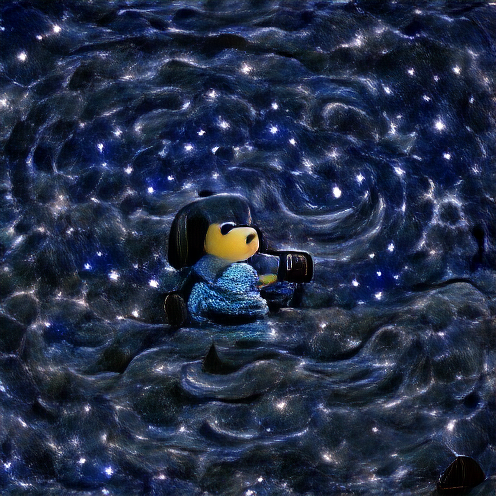

In [21]:
gen(imagine, latent_text_dict["night"])

In [8]:
print(latent_dict.keys())
print(latent_text_dict.keys())

dict_keys(['logo_black', 'logo_purple', 'earth', 'stance'])
dict_keys(['night', 'apocalpyse', 'psych'])


In [58]:
# earth, logo_black, logo_purple, stance
prompt = "apocalpyse"

mode = "translate_opt" # rotate, transition, translate_opt
latent = latent_dict[prompt] if prompt in latent_dict else latent_text_dict[prompt]

if mode == "rotate":
    angles = torch.arange(0, 360, 1).tolist()
    # Generate arrays for rotation
    latent_transition = [TF.rotate(latent, angle, expand=0, fill=None) for angle in angles]
elif mode == "transition":
    start = "earth"
    end = "logo_black"
    steps = 100
    start_latent, end_latent = latent_dict[start], latent_dict[end]
    # interpolate
    # Obtain evenly-spaced ratios between 0 and 1
    linspace = torch.linspace(0, 1, steps)
    # Generate arrays for interpolation using ratios
    latent_transition = [(1 - l) * start_latent + l * end_latent for l in linspace]
elif mode == "translate_opt":
    # how to make a loop:
    """
    Looping technique is roughly the same as https://twitter.com/genekogan/status/918513720481009666

Gist is to regenerate each frame in the loop N times, initializing it 
from a mixture of the previous (t-1) and next (t+1) frame,
gradually interpolating from 100% t-1 to 100% t+1. A bit clunky, but it works.
    """
    
    total_steps = 100
    pixel_step_size_x = 0
    pixel_step_size_y = 0
    opt_steps = 10
    zoom_factor = 0.9
    #zoom_factor = 1#1.02
    angle = 0
    
    
    imagine.set_clip_encoding(text=prompt)#, img=path_dict[prompt], encoding=None)
    
    latent_transition = [latent]
    for _ in tqdm(range(total_steps)):
        # recreate img
        img = decode(imagine, latent)
        # transform it
        transformed = T.functional.affine(img, angle=angle, translate=(pixel_step_size, pixel_step_size_y), scale=zoom_factor, shear=0)#, scale: float, shear: List[float],
            #interpolation: InterpolationMode = InterpolationMode.NEAREST, fill: Optional[List[float]] = None,
            #resample: Optional[int] = None, fillcolor: Optional[List[float]] = None)
       
        # encode it again
        latent, _, [_, _, indices] = vqgan.encode(transformed.to(imagine.device).mul(2).sub(1))
        
        # set latent in imagine properly such that it can be optimized by the optimzier
        imagine.set_latent(latent)
        
        for _ in range(opt_steps):
            imagine.train_step(0, 0)
            
        # get new latents
        latent = imagine.model.model.latents.detach().cpu()
        # store latents
        latent_transition.append(latent)

  0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
# generate images from latents
def gen_imgs(imagine, latents):
    images = []
    for latent in tqdm(latent_transition):
        model = imagine.model.model
        model.latents = latent.to("cuda")
        image = model(return_loss=False)
        image = image.detach().cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1) * 255
        image = image.type(torch.uint8).clamp(0, 255)
        images.append(image)
    return images
images = gen_imgs(imagine, latents)

  0%|          | 0/101 [00:00<?, ?it/s]

In [60]:

folder = mode
os.makedirs(folder, exist_ok=1)

time_str = time.strftime("%X_%x", time.gmtime()).replace("/", "_")
path = os.path.join(folder, time_str + "_" + (f"{start}_to_{end}_{steps}.mp4" if mode == "transition" else f"{prompt}.mp4"))
imageio.mimwrite(path, images)